In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [2]:

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x


In [3]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [23]:
class FrozenLakeDQL():
    # Hyperparameters
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)    
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    
    
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        hidden_layer=10
        
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Policy network optimizer.  
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
            
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions    

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql_model.pt")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('frozen_lake_dql_model.png')
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []
        # print(mini_batch)
        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        # print("target: ",target)
        # print("current_q: ",current_q)
        # print("current_q_list: ",current_q_list)
        # print("action: ",action)
        # print("target_q: ",target_q)
        # print("target_q_list: ",target_q_list)
        # print("loss: ",loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts an state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql_model.pt"))
        policy_dqn.eval()    # switch model to evaluation mode


        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

    


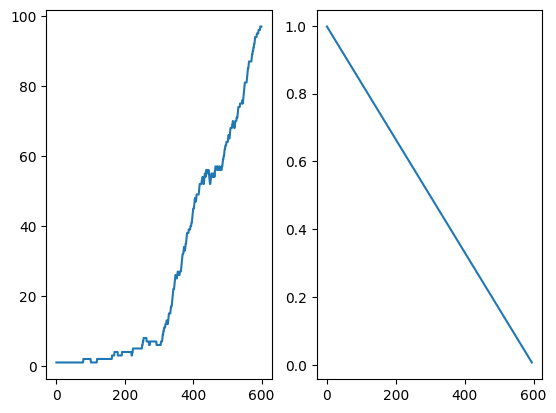

In [26]:
frozen_lake = FrozenLakeDQL()
is_slippery = False
frozen_lake.train(600, is_slippery=is_slippery)


In [25]:
frozen_lake.test(2, is_slippery=is_slippery)